# RODD disturbance estimation using Variational Inference with Pyro

In [1]:
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import (SVI, TraceEnum_ELBO, config_enumerate, 
                        infer_discrete)
from pyro.infer.autoguide import AutoDelta

smoke_test = ('CI' in os.environ)

In [2]:
from platform import python_version
python_version()

'3.9.9'

In [3]:
pyro.set_rng_seed(101)
pyro.__version__

'1.8.0'

In [4]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Inferring the parameters of a stochastic process with a discrete random decision variable

Suppose we have a noisy measurement of a disturbance process that looks like a series of randomly-occurring step changes:

<img src="images/Wong_and_Lee_fig1c_steps.png" width="320">

<center> Figure source: Wong and Lee (2009)</center>

We could generate a disturbance like this by integrating a 'random shock' variable which is sampled from either of two normal distributions, according to a discrete random variable $\gamma(k)$ which is either 0 or 1:

$$
\gamma(k) \sim
\begin{cases}
0 & \text{with probability } 1-\epsilon \\
1 & \text{with probability } \epsilon
\end{cases}
$$

where $\epsilon<<1$.

<img src="images/shock_dist_1.png" width="320">
<img src="images/shock_dist_2.png" width="320">

In general, the discrete-time model for the disturbance is:

$$p(k) = \frac{B(q^-1)}{A(q^-1)} w_p(k)$$

This is known as a randomly-occurring deterministic disturbance (RODD) (MacGregor et al. 1984).

Here, we are considering the case $\frac{B(q^-1)}{A(q^-1)}=\frac{1}{1 - q^{-1}}$.

Reference:

- MacGregor, J.F., Harris, T.J., and Wright, J.D. (1984). Duality Between the Control of Processes Subject to Randomly Occurring Deterministic Disturbances and ARIMA Stochastic Disturbances. Technometrics, 26(4), 389–397.

Suppose we have initial guesses of the shock probability $\epsilon$, the variance of the signal when there is no shock $\sigma_{w_p}^2$, and when a shock occurs $b^2\sigma_{w_p}^2$:

In [5]:
epsilon_guess = 0.05
b_guess = 50
scale_guess = 0.03

## Data model

First, we construct a model of our belief about the process that generated the data:

Disturbance generating process

$$
w_{p}(k) \sim
\begin{cases}
\mathcal{N}(0, \sigma_{w_p}^2) & \text{with probability } 1-\epsilon \\
\mathcal{N}(0, b^2 \sigma_{w_p}^2) & \text{with probability } \epsilon
\end{cases}
$$

Disturbance measurement process

$$ w_{p,M}(k) \sim \mathcal{N}(w_{p}(k), \sigma_{M}^2)$$

## Log Normal distribution

mean = 1.0317434072494507


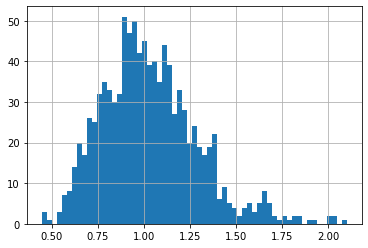

In [6]:
param_guess = 1
test_dist = dist.LogNormal(np.log(param_guess), 0.25)
print(f"mean = {test_dist.mean}")
samples = [test_dist.sample().item() for _ in range(1000)]
plt.hist(samples, bins=61)
plt.grid()
plt.show()

## 1.  Define a stochastic function

 - See: http://pyro.ai/examples/intro_part_i.html

### Random Shock Model

In [7]:
def random_shocks(scale_guess, b_guess, epsilon_guess):
    # Scale and b are always positive
    scale = pyro.sample("scale", dist.LogNormal(np.log(scale_guess), 0.25))
    b = pyro.sample("b", dist.LogNormal(np.log(b_guess), 0.25))
    epsilon = pyro.sample("epsilon", dist.LogNormal(np.log(epsilon_guess), 0.25))
    alpha = pyro.sample("alpha", dist.Bernoulli(epsilon))
    alpha = alpha.long()
    wp_dist = dist.Normal(torch.tensor([0.0, 0.0])[alpha], 
                          torch.tensor([scale, scale*b])[alpha])
    measurement = pyro.sample('obs', wp_dist)
    return measurement

def random_shocks_conditioned(scale_guess, b_guess, epsilon_guess, observations):
    # Scale and b are always positive
    scale = pyro.sample("scale", dist.LogNormal(np.log(scale_guess), 0.25))
    b = pyro.sample("b", dist.LogNormal(np.log(b_guess), 0.25))
    epsilon = pyro.sample("epsilon", dist.LogNormal(np.log(epsilon_guess), 0.25))
    alpha = pyro.sample("alpha", dist.Bernoulli(epsilon))
    alpha = alpha.long()
    wp_dist = dist.Normal(torch.tensor([0.0, 0.0])[alpha], 
                          torch.tensor([scale, scale*b])[alpha])
    with pyro.plate("N", observations.shape[0]):
        measurement = pyro.sample('obs', wp_dist, obs=observations)

### Sampling from the model

In [8]:
# Draw random samples
for _ in range(5):
    print(random_shocks(scale_guess, b_guess, epsilon_guess))

tensor(-0.0070)
tensor(-0.0615)
tensor(0.0015)
tensor(-0.0171)
tensor(-0.0360)


## Generate a dataset

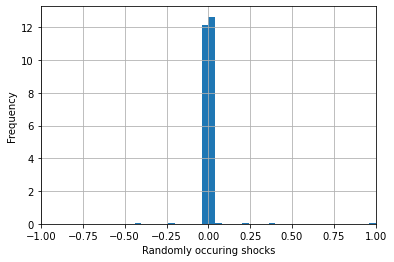

In [9]:
# Parameters
true_scale = 0.01
true_b = 100
true_epsilon = 0.01

wp_measurements = [random_shocks(true_scale, true_b, true_epsilon).item()
                   for _ in range(1000)]

x_minmax = true_scale * true_b * np.array([-1 , 1])

plt.hist(wp_measurements, bins=np.linspace(*x_minmax, 51), 
         density=True)
plt.xlim(x_minmax)
plt.xlabel('Randomly occuring shocks')
plt.ylabel('Frequency')
plt.grid()
plt.savefig(os.path.join(plot_dir, 'wp_samples.png'))
plt.show()

In [10]:
# Choose how much data to provide
data = torch.tensor(wp_measurements)

## 2. Variational Inference

### Guide function

The guide function represents the family of distributions we want to consider as our posterior distribution. In this case, it is obvious that the distribution is a Gaussian mixture model with 2 components.

The function below is based on example code here: https://pyro.ai/examples/gmm.html

This model below allows different scale for each mixture.

In [11]:
K = 2  # Number of mixture components (fixed)

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    with pyro.plate('components', K):
        scales = pyro.sample('scales', dist.LogNormal(0., 2.))
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scales[assignment]), 
                    obs=data)

### Optimizer

In [12]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

Before inference we’ll initialize to plausible values. **Mixture models are very succeptible to local modes**. A common approach is choose the best among many randomly initializations, where the cluster means are initialized from random subsamples of the data. Since we’re using an `AutoDelta` guide, we can initialize by defining a custom `init_loc_fn()`.

In [13]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scales":
        # Initialise std. dev's. to std. dev of data
        return (data.var() * torch.ones(K) / 2).sqrt()
    if site["name"] == "locs":
        # Initialise means to two randomly chosen data points
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(
        pyro.poutine.block(model, expose=['weights', 'locs', 'scales']), 
        init_loc_fn=init_loc_fn
    )
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 1, initial_loss = -718.1073608398438


During training, we’ll collect both losses and gradient norms to monitor convergence. We can do this using PyTorch’s `.register_hook()` method.

In [14]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(
        lambda g, name = name: gradient_norms[name].append(g.norm().item())
    )

losses, params  = [], []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

In [15]:
# Find lowest point in training
iter_best = np.argmin(losses)
iter_best

193

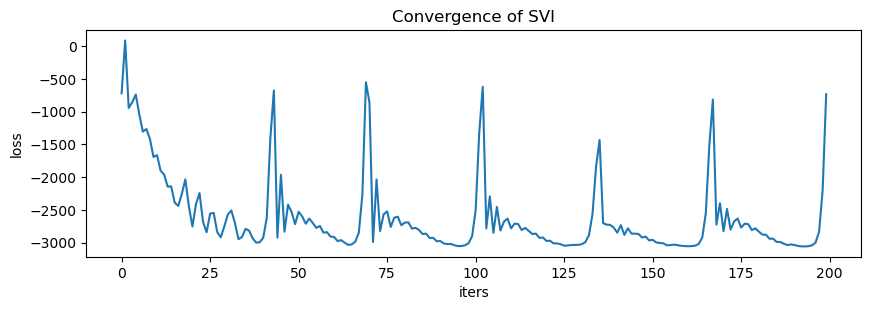

In [16]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
#plt.yscale('log')
plt.title('Convergence of SVI');

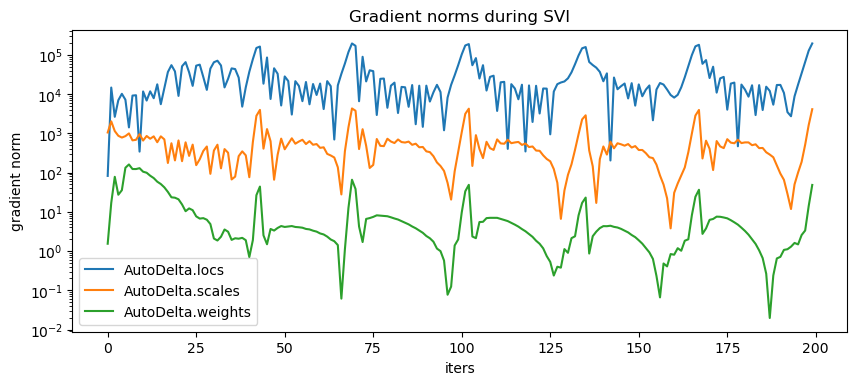

In [17]:
plt.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    plt.plot(grad_norms, label=name)
plt.xlabel('iters')
plt.ylabel('gradient norm')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Gradient norms during SVI');

In [18]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scales = map_estimates['scales']

## Visualize the mixture model

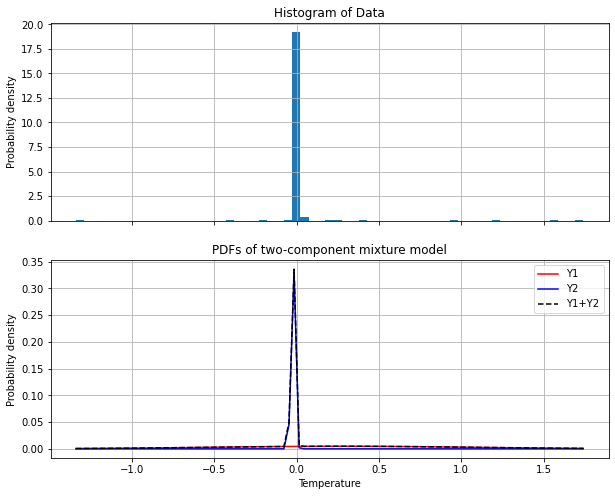

Estimates                   True Parameters             
--------------------------------------------------------------------------------
weights = [0.012 0.988]     true_epsilon = 0.01
locs = [ 0.274 -0.023]      true_means = [0, 0]
scales = [0.79  0.012]      true_scales = array([0.01, 1.  ])


In [19]:
nobs, minmax, mean, variance, _, _ = scipy.stats.describe(wp_measurements)

X = np.linspace(*minmax ,101)
Y1 = weights[0].item() * scipy.stats.norm.pdf(
    (X - locs[0].item()) / scales[0].item()
)
Y2 = weights[1].item() * scipy.stats.norm.pdf(
    (X - locs[1].item()) / scales[1].item()
)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax = axes[0]
ax.hist(wp_measurements, bins=61, density=True)
ax.set_ylabel('Probability density')
ax.grid()
ax.set_title('Histogram of Data')

ax = axes[1]
ax.plot(X, Y1, 'r-', label='Y1')
ax.plot(X, Y2, 'b-', label='Y2')
ax.plot(X, Y1 + Y2, 'k--', label='Y1+Y2')
#ax.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
ax.set_title('PDFs of two-component mixture model')
ax.set_xlabel('Temperature')
ax.set_ylabel('Probability density')
ax.legend()
ax.grid()

plt.savefig(os.path.join(plot_dir, 'rv-dist-est.pdf'), dpi=300)
plt.show()

print(f"{'Estimates':27s} {'True Parameters':27s} ")
print("-"*80)
print(f"weights = {weights.data.numpy().round(3)}     {true_epsilon = }")
print(f"locs = {locs.data.numpy().round(3)}      true_means = [0, 0]")
true_scales = np.array([true_scale, true_b*true_scale])
print(f"scales = {scales.data.numpy().round(3)}      {true_scales = }")